In [39]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import argparse
import imutils
WORKPATH = "D:/GameProjects/Kartrider/SmartKartRider"
RAW_DATA_PATH = WORKPATH + "/raw_data/US"

In [473]:
class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # 初始化形状名称并近似轮廓
        shape = "unidentified"
        peri = cv.arcLength(c, True)
        print("peri: ", peri)
        approx = cv.approxPolyDP(c, 0.10* peri, True)
        # approx = cv.approxPolyDP(c, 0.04 * peri, True)
        # 如果形状是一个三角形，它将有3个顶点
        if len(approx) == 3:
            shape = "triangle"
        # 如果形状有4个顶点，它要么是正方形，要么是矩形
        elif len(approx) == 4:
            # 计算轮廓的包围框，并使用包围框计算高宽比
            (x, y, w, h) = cv.boundingRect(approx)
            ar = w / float(h)
            # 正方形的长宽比大约等于1，否则，形状就是矩形
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # 如果形状是一个五边形，它将有5个顶点
        elif len(approx) == 5:
            shape = "pentagon"
        # 否则，我们假设形状是一个圆
        else:
            shape = "circle"
        # 返回形状的名称
        return shape, approx

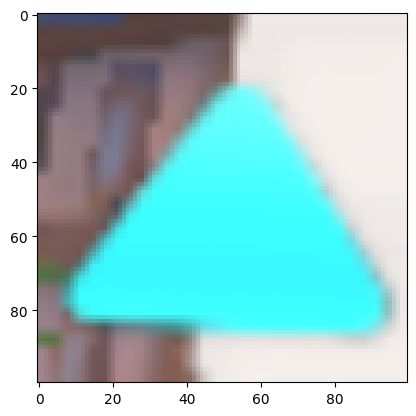

In [474]:
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", default="inpaint.jpg", help="path to the input image")
# args = vars(ap.parse_args())
target_size = (100, 100)
img = cv.resize(cv.imread(RAW_DATA_PATH + '/SmallMap/6.png')[80:110, 85:115], target_size)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [475]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

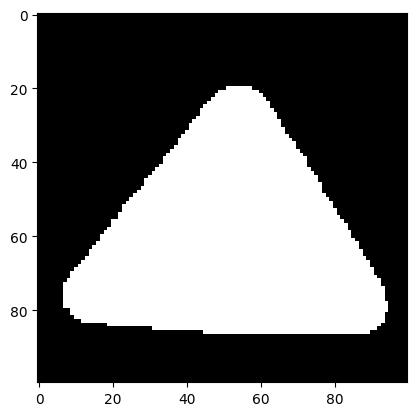

In [476]:
lower_green = np.array([80, 80, 120]) #BGR
upper_green = np.array([120, 255,255])

#create a mask for green colour using inRange function
mask = cv.inRange(hsv, lower_green, upper_green)

#perform bitwise and on the original image arrays using the mask
res = cv.bitwise_and(img, img, mask=mask)

#create resizable windows for displaying the images
# cv.namedWindow("res", cv.WINDOW_NORMAL)
# cv.namedWindow("hsv", cv.WINDOW_NORMAL)
# cv.namedWindow("mask", cv.WINDOW_NORMAL)

# #display the images
# cv.imshow("mask", mask)
# cv.imshow("hsv", hsv)
# cv.imshow("res", res)
#
# if cv.waitKey(0):
#     cv.destroyAllWindows()
plt.imshow(mask, cmap="gray")

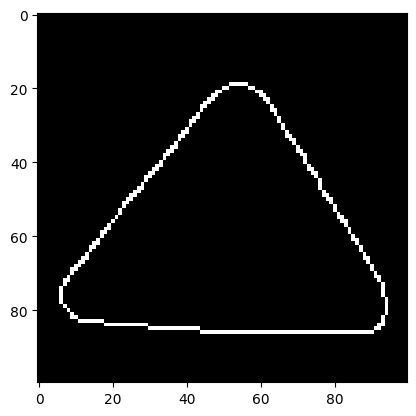

In [477]:
canny = cv.Canny(mask,50,50)
# cv.imshow("canny", canny)|
#
# if cv.waitKey(0):
#     cv.destroyAllWindows()
plt.imshow(canny, cmap="gray")

In [478]:
cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,
                        cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

peri:  254.45079028606415
triangle [[ 7 73]
 [94 80]
 [57 20]]


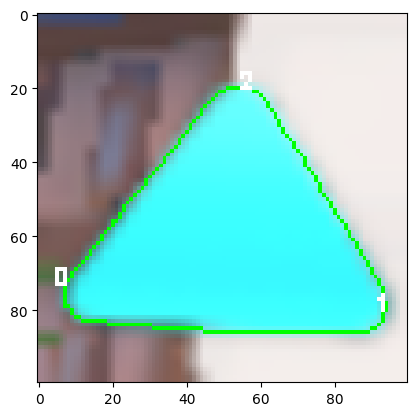

In [479]:
final_img = img.copy()
for c in cnts:
    # 计算轮廓的中心，然后仅使用轮廓检测形状的名称
    M = cv.moments(c)
    cX = int((M["m10"] / M["m00"]) )
    cY = int((M["m01"] / M["m00"]) )
    shape, train_points = sd.detect(c)
    train_points = train_points.reshape(len(train_points), -1)
    # 将轮廓(x, y)坐标乘以调整比例，然后在图像上绘制轮廓和形状的名称
    cv.drawContours(final_img, [c], -1, (0, 255, 0), 1)
    cv.putText(final_img, "0", (train_points[0, 0]-3, train_points[0, 1]), cv.FONT_HERSHEY_SIMPLEX,
                0.2, (255, 255, 255), 1)

    cv.putText(final_img, "1", (train_points[1, 0]-3, train_points[1, 1]), cv.FONT_HERSHEY_SIMPLEX,
            0.2, (255, 255, 255), 1)

    cv.putText(final_img, "2", (train_points[2, 0]-3, train_points[2, 1]), cv.FONT_HERSHEY_SIMPLEX,
            0.2, (255, 255, 255), 1)
    print(shape, train_points)
    plt.imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

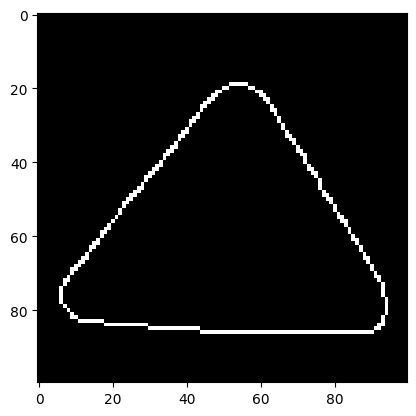

In [480]:
plt.imshow(canny, cmap="gray")

In [481]:
lines = cv.HoughLines(canny, 260, np.pi / 180, 50)
lines.shape

(1, 1, 2)

In [482]:
# for i in range(100):
#     for j in range(180):
#         lines = cv.HoughLines(canny, 1.0/(i+1), np.pi / 180, j+1)
#         if len(lines) != 0 or :
#             print(i, j)
# # lines1 = lines[:, 0, :]
# # for rho, theta in lines1[:]:
# #     a = np.cos(theta)
# #     b = np.sin(theta)
# #     x0 = a * rho
# #     y0 = b * rho
# #     x1 = int(x0 + 3000 * (-b))
# #     y1 = int(y0 + 3000 * (a))
# #     x2 = int(x0 - 3000 * (-b))
# #     y2 = int(y0 - 3000 * (a))
# #     cv.line(img.copy(), (x1, y1), (x2, y2), (0, 0, 255), 2)


In [483]:
k_left_vet_index, k_up_vet_index = np.argmin(train_points.reshape(len(train_points), -1), axis = 0)
k_right_vet_index  = np.argmax(train_points.reshape(len(train_points), -1), axis = 0)[0]
k_left_vet = train_points[k_left_vet_index]
k_right_vet = train_points[k_right_vet_index]
k_up_vet = train_points[k_up_vet_index]
k_mid_down_vet = (k_right_vet + k_left_vet)/2
k_dir_vet = k_up_vet - k_mid_down_vet
up_norm = np.array([0, -1])
k_dir_vet

array([  6.5, -56.5])

In [452]:
import math

def angle_of_vector(v1, v2):
    pi = math.pi
    vector_prod = v1[0] * v2[0] + v1[1] * v2[1]
    length_prod = math.sqrt(pow(v1[0], 2) + pow(v1[1], 2)) * math.sqrt(pow(v2[0], 2) + pow(v2[1], 2))
    cos = vector_prod * 1.0 / (length_prod * 1.0 + 1e-6)
    return (math.acos(cos) / pi) * 180

In [453]:
angle_of_vector(k_dir_vet, up_norm)

4.436487179884464